# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import stats
import re

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split

import xgboost as xgb
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential

from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

# Loading Data

In [2]:
data = pd.read_csv('SolarPrediction.csv')

In [3]:
data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


# Data Wrangling

In [5]:
df = data.copy()

In [6]:
st = '9/29/2016 12:00:00 AM'
st.split()[0]

'9/29/2016'

In [7]:
df['Data'] = df['Data'].apply(lambda x: x.split()[0])

In [8]:
df['Month'] = pd.to_datetime(df['Data']).dt.month
df['Day'] = pd.to_datetime(df['Data']).dt.day
df['Hour'] = pd.to_datetime(df['Time']).dt.hour
df['Minute'] = pd.to_datetime(df['Time']).dt.minute
df['Second'] = pd.to_datetime(df['Time']).dt.second

In [9]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24


In [10]:
df.drop(columns={'Data', 'Time'}, inplace= True)

In [11]:
df['risehour'] = df['TimeSunRise'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
df['riseminuter'] = df['TimeSunRise'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

df['sethour'] = df['TimeSunSet'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
df['setminute'] = df['TimeSunSet'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

In [12]:
df.head()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
0,1475229326,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26,6,13,18,13
1,1475229023,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23,6,13,18,13
2,1475228726,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26,6,13,18,13
3,1475228421,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21,6,13,18,13
4,1475228124,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24,6,13,18,13


In [13]:
df.drop(['UNIXTime','TimeSunRise', 'TimeSunSet'], axis = 1, inplace = True)


In [14]:
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
0,1.21,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,1.21,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,1.23,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13
3,1.21,48,30.46,60,137.71,3.37,9,29,23,40,21,6,13,18,13
4,1.17,48,30.46,62,104.95,5.62,9,29,23,35,24,6,13,18,13


In [15]:
df.shape

(32686, 15)

In [16]:
df.isnull().sum().sum()

0

In [17]:
input_features = df.drop('Radiation', axis=1)
target_features = df['Radiation']

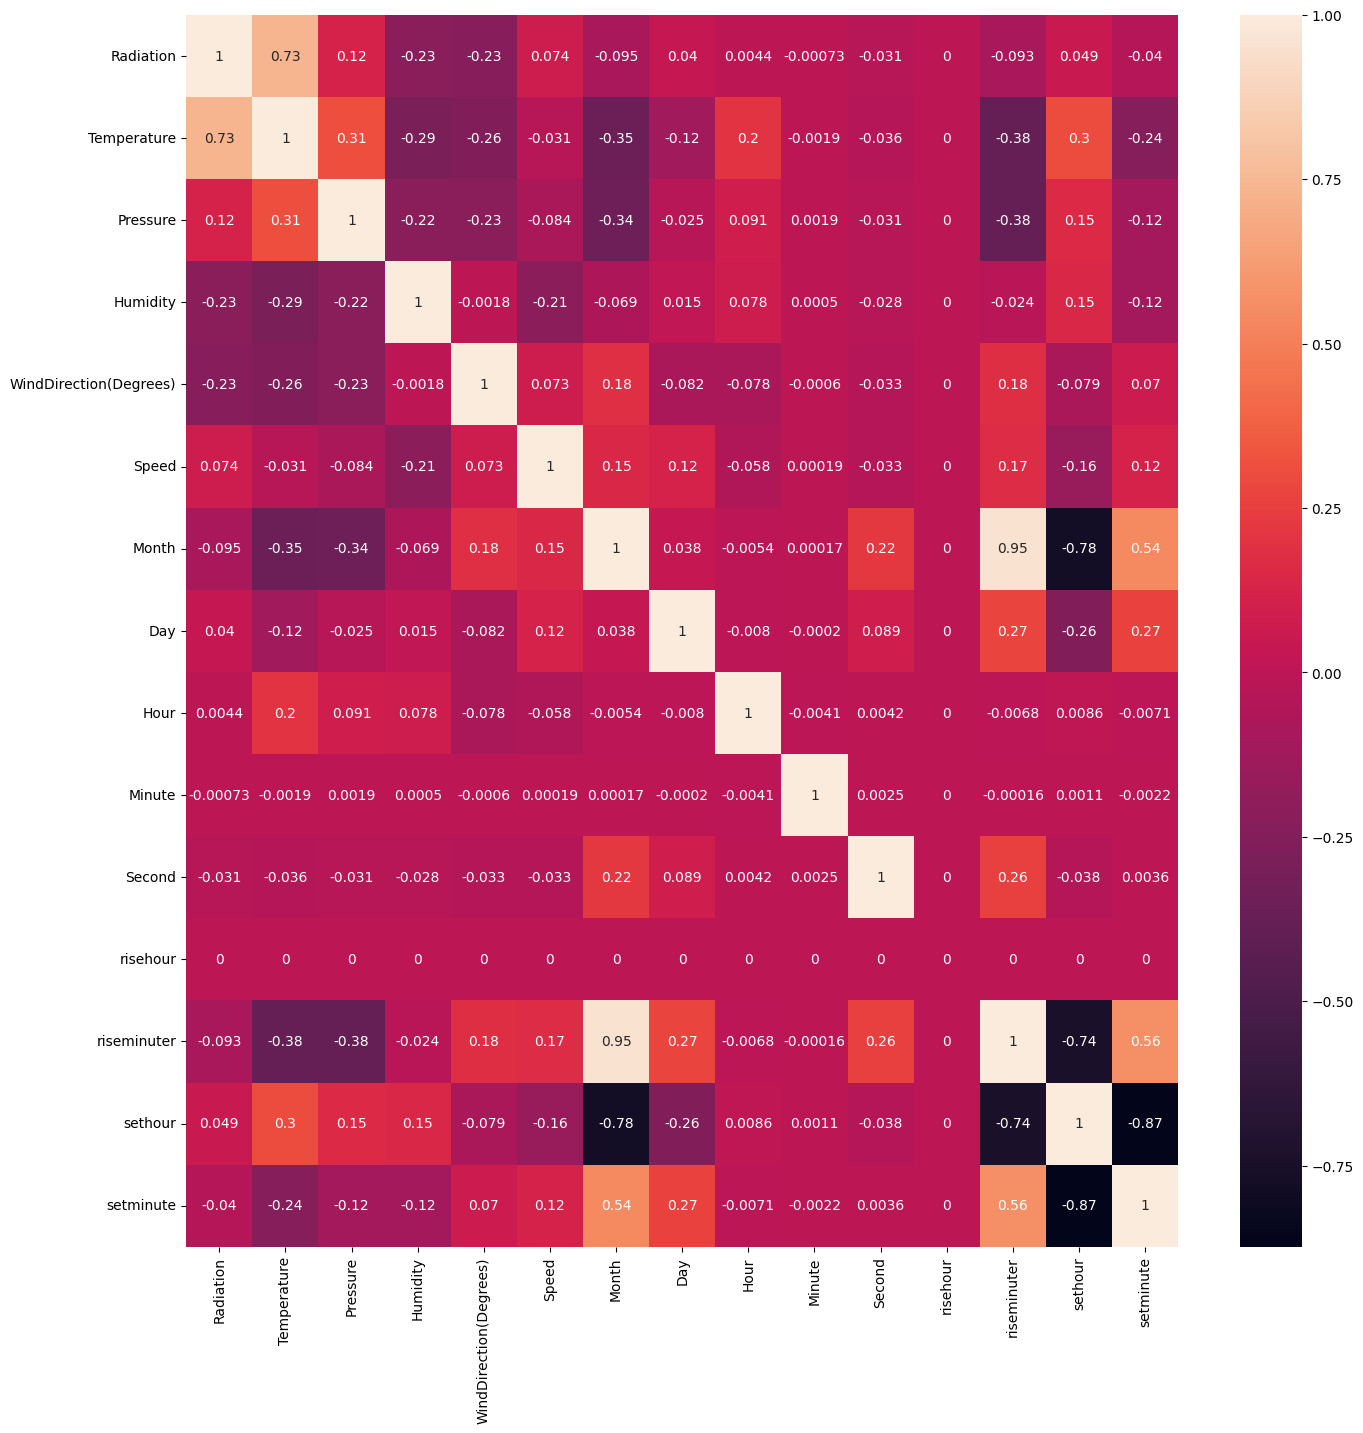

In [18]:
corr_matrix = df.corr()
sns.set_palette(palette='Spectral')
plt.figure(figsize=(16, 16))
sns.heatmap(data=corr_matrix.fillna(0), annot=True)
plt.show()

# Feature Selection using Correlation Matrix

In [19]:
bestfeatures = SelectKBest(score_func=chi2, k=10)

In [20]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(target_features)

In [21]:
train_y

array([ 9,  9, 11, ...,  8, 11,  8], dtype=int64)

In [22]:
target_features

0        1.21
1        1.21
2        1.23
3        1.21
4        1.17
         ... 
32681    1.22
32682    1.17
32683    1.20
32684    1.23
32685    1.20
Name: Radiation, Length: 32686, dtype: float64

In [23]:
target_cont = df['Radiation'].apply(lambda x:int(x*100))
target_cont[:5]

0    121
1    121
2    123
3    121
4    117
Name: Radiation, dtype: int64

In [24]:
scaled_input_features = MinMaxScaler().fit_transform(input_features)
fit = bestfeatures.fit(scaled_input_features, target_cont)

In [25]:
scores = pd.DataFrame(fit.scores_)
column = pd.DataFrame(input_features.columns)
featureScores = pd.concat([column, scores], axis = 1)
featureScores.columns = ['Features','Feature_imp']
featureScores.sort_values(by = 'Feature_imp', ascending= False, inplace = True)

In [26]:
featureScores

,Features,Feature_imp
12,sethour,12207.531454
5,Month,4684.579610
11,riseminuter,4015.062771
3,WindDirection(Degrees),3271.827277
6,Day,2841.926850
8,Minute,2702.449333
9,Second,2288.673032
13,setminute,1863.712087
0,Temperature,1651.685632
2,Humidity,1588.087433


Text(0.5, 1.0, 'Feature Importance Using SelectKBest')

<Figure size 1000x800 with 0 Axes>

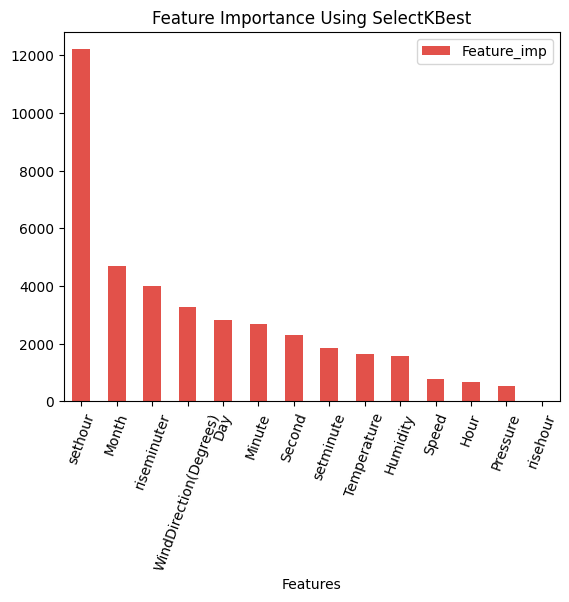

In [27]:
plt.figure(figsize= (10,8))
featureScores.plot.bar(x = 'Features', y = 'Feature_imp')
plt.xticks(rotation = 70)
plt.title("Feature Importance Using SelectKBest")


# Feature Selection using Extra Tree Classifier

In [28]:
model = ExtraTreesClassifier(n_estimators=3, verbose=2)
model.fit(scaled_input_features,target_cont)

building tree 1 of 3
building tree 2 of 3
building tree 3 of 3


ExtraTreesClassifier(n_estimators=3, verbose=2)

In [29]:
feature_importances = pd.DataFrame(model.feature_importances_, index = input_features.columns, columns = ["feature_imp"])
feature_importances.sort_values(by = 'feature_imp', ascending=False, inplace = True)
feature_importances

,feature_imp
WindDirection(Degrees),0.157892
Minute,0.148534
Speed,0.124443
Second,0.121778
Humidity,0.109621
Hour,0.088414
Temperature,0.081314
Pressure,0.074190
Day,0.037216
setminute,0.025975


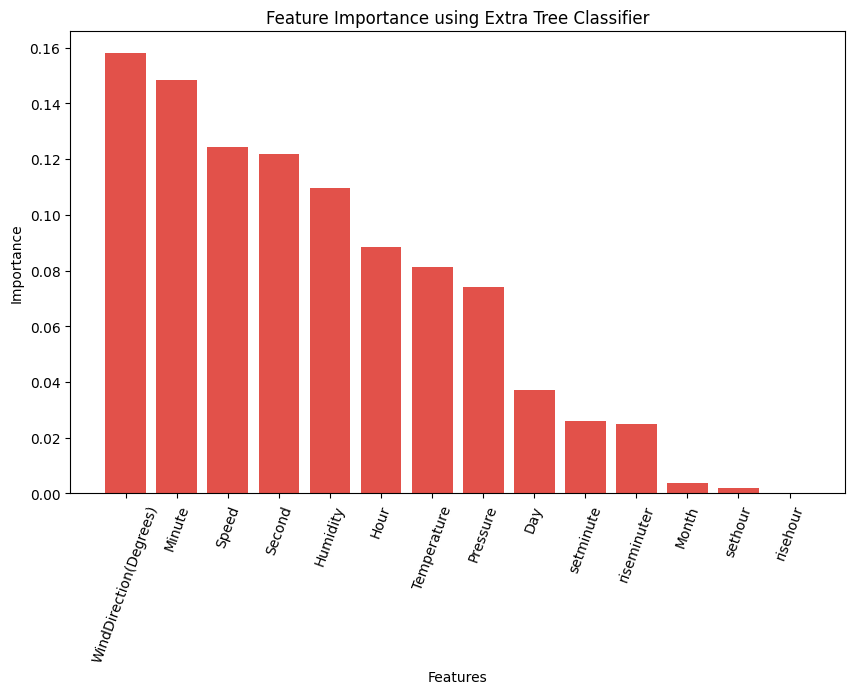

In [31]:
plt.figure(figsize = (10, 6))
plt.bar(feature_importances.index, feature_importances["feature_imp"])
plt.xticks(rotation = 70)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance using Extra Tree Classifier")
plt.show()

# Feature Engineering with BoxCox, Log, Min-Max and Standard transformation

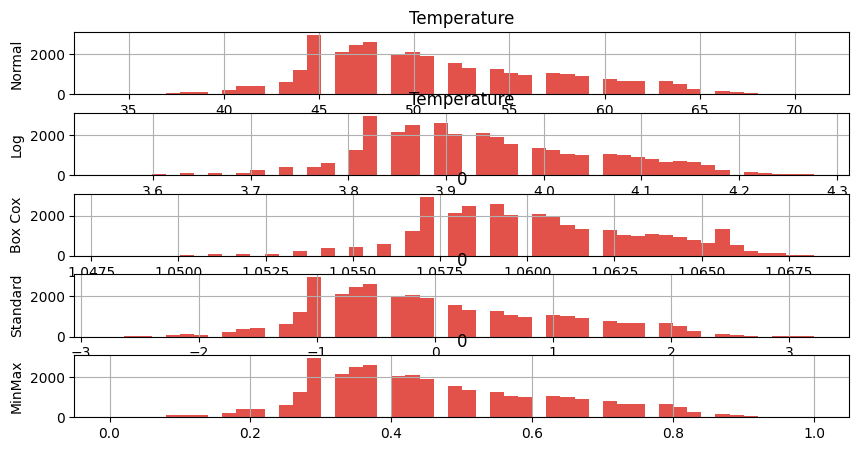

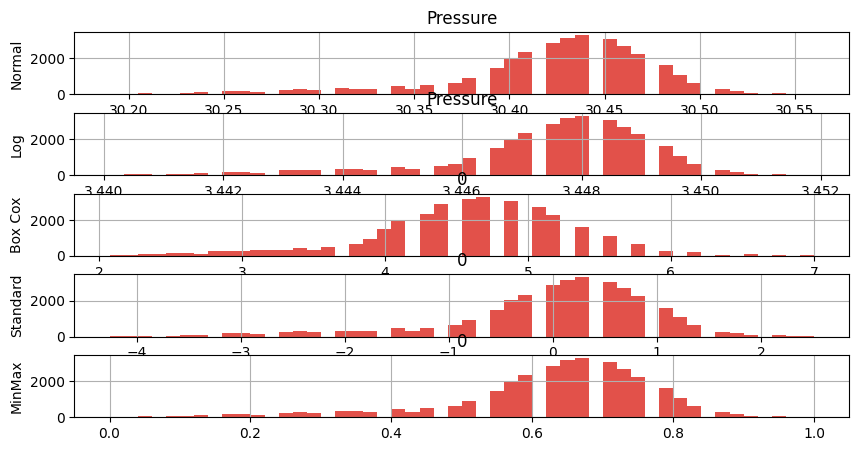

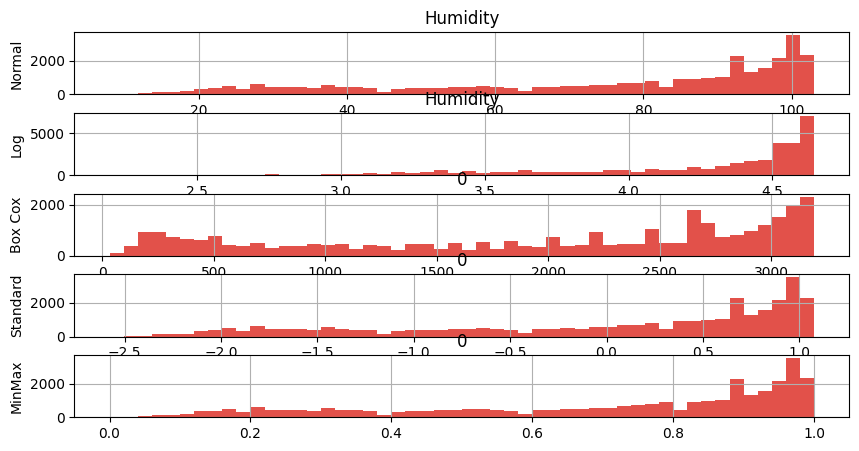

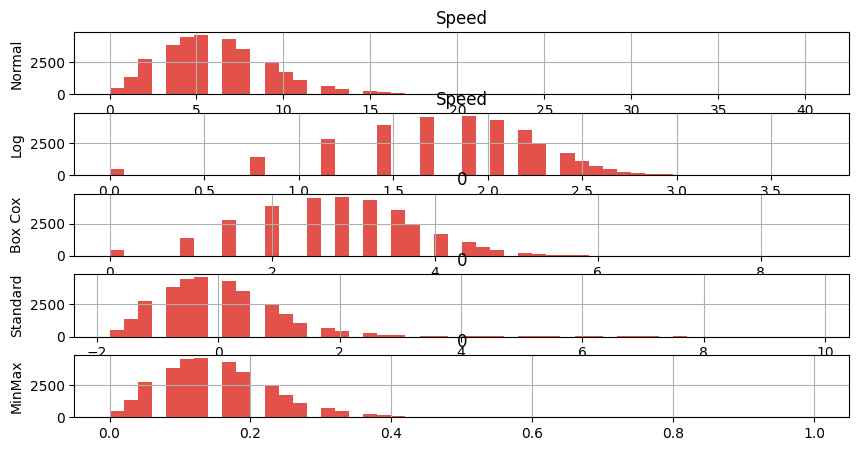

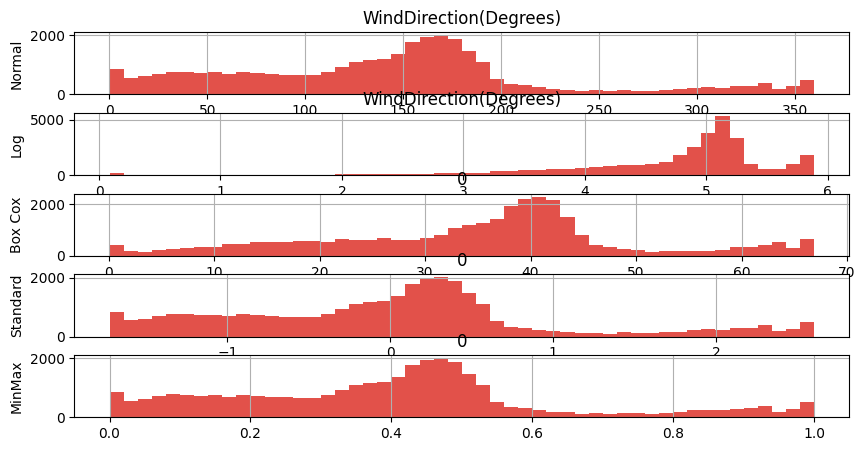

In [32]:
features_to_transform = ['Temperature', 'Pressure', 'Humidity', 'Speed', 'WindDirection(Degrees)']

for i in features_to_transform:
    
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(10, 5))
    
    pd.DataFrame(input_features[i]).hist(ax = ax1, bins = 50)
    pd.DataFrame((input_features[i]+1).transform(np.log)).hist(ax = ax2, bins = 50)
    pd.DataFrame(stats.boxcox(input_features[i]+1)[0]).hist(ax = ax3, bins = 50)    
    pd.DataFrame(StandardScaler().fit_transform(np.array(input_features[i]).reshape(-1, 1))).hist(ax = ax4, bins = 50)
    pd.DataFrame(MinMaxScaler().fit_transform(np.array(input_features[i]).reshape(-1, 1))).hist(ax = ax5, bins = 50)
    
    ax1.set_ylabel('Normal')
    ax2.set_ylabel('Log')
    ax3.set_ylabel('Box Cox')
    ax4.set_ylabel('Standard')
    ax5.set_ylabel('MinMax')

In [33]:
transform = {'Temperature' : (input_features['Temperature']+1).transform(np.log), 
             'Pressure': stats.boxcox(input_features['Pressure']+1)[0], 
            'Humidity' : stats.boxcox(input_features['Humidity']+1)[0], 
            'Speed' : (input_features['Speed']+1).transform(np.log), 
            'WindDirection(Degrees)' : MinMaxScaler().fit_transform(
                np.array(input_features['WindDirection(Degrees)']).reshape(-1, 1))}

for i in transform:
    input_features[i] = transform[i]

In [34]:
input_features.head()

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
0,3.89182,5.044903e+152,1139.358665,0.492692,1.890095,9,29,23,55,26,6,13,18,13
1,3.89182,5.044903e+152,1104.046980,0.490996,1.474763,9,29,23,50,23,6,13,18,13
2,3.89182,5.044903e+152,1069.253545,0.440894,1.474763,9,29,23,45,26,6,13,18,13
3,3.89182,5.044903e+152,1175.187489,0.382426,1.474763,9,29,23,40,21,6,13,18,13
4,3.89182,5.044903e+152,1248.392213,0.291391,1.890095,9,29,23,35,24,6,13,18,13


# Preparing data - Standardisation and Splitting

In [36]:
xtrain, xtest, ytrain, ytest = train_test_split(input_features, target_features, test_size=0.2, random_state=1)

scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [37]:
xtrain.shape, xtest.shape

((26148, 14), (6538, 14))

# Prediction with XGBoost


In [38]:
params = {
    'learning_rate': 0.1,
    'max_depth': 8}

from xgboost import XGBRegressor
model = XGBRegressor(**params)

In [39]:
model.fit(xtrain, ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [40]:
y_pred = model.predict(xtest)

In [41]:
print('XGBoost model result: {0:0.4f}'. format(np.sqrt(mean_squared_error(ytest, y_pred))))

XGBoost model result: 81.8749


In [42]:
rmse = np.sqrt(mean_squared_error(ytest, y_pred))
r2 = r2_score(ytest, y_pred)

print("Testing performance")

print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))

Testing performance
RMSE: 81.87
R2: 0.93


# Using MultiLayer Perceptron for prediction

In [44]:
xtrain, xtest, ytrain, ytest = train_test_split(input_features, target_features, test_size=0.2, random_state=1)

scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [47]:
model = Sequential()

model.add(Dense(128, activation='relu', input_dim=14))
model.add(Dropout(0.33))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(1, activation='linear'))

model.compile(metrics=['mse'], loss='mae', optimizer=Adam(learning_rate=0.001))
print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [48]:
history = model.fit(xtrain, ytrain, validation_split=0.1, epochs=50, batch_size=32)

Epoch 1/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 158.1256 - mse: 90076.3828 - val_loss: 77.0497 - val_mse: 22379.7129
Epoch 2/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 87.1733 - mse: 29246.1348 - val_loss: 69.3379 - val_mse: 18540.6035
Epoch 3/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 80.8122 - mse: 25144.6055 - val_loss: 67.7435 - val_mse: 17593.8496
Epoch 4/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 78.4630 - mse: 23564.1133 - val_loss: 63.2865 - val_mse: 15653.8682
Epoch 5/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 75.3540 - mse: 21956.0781 - val_loss: 59.4162 - val_mse: 14156.1104
Epoch 6/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 74.5956 - mse: 21346.8242 - val_loss: 59.1001 - val_mse: 14361.8525
Epoch 7/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 72.8953 - mse: 20747.6035 - val_loss: 56.7517 - val_mse: 13457.2725
Epoch 8/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 73.0155 - mse: 20799.3398 - val_loss: 52.74

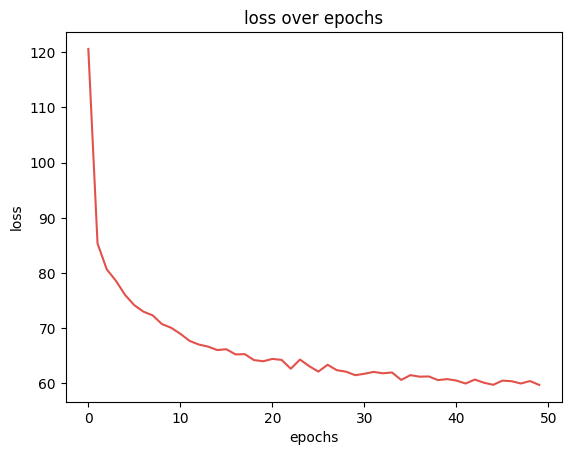

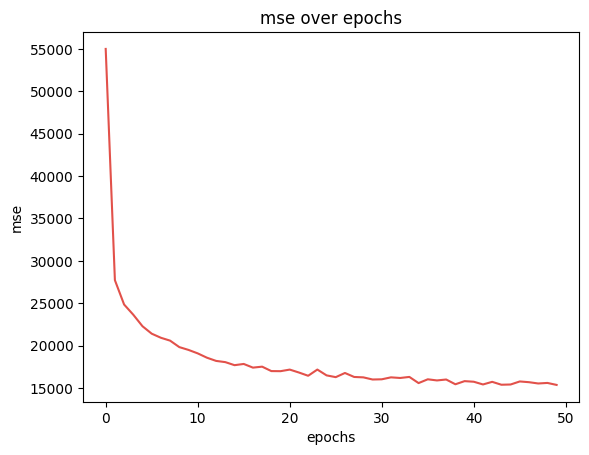

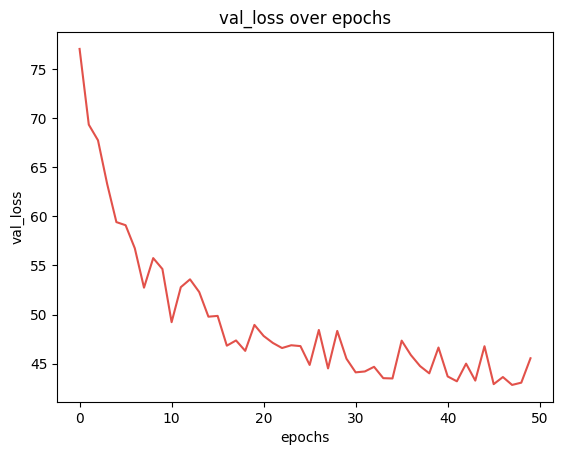

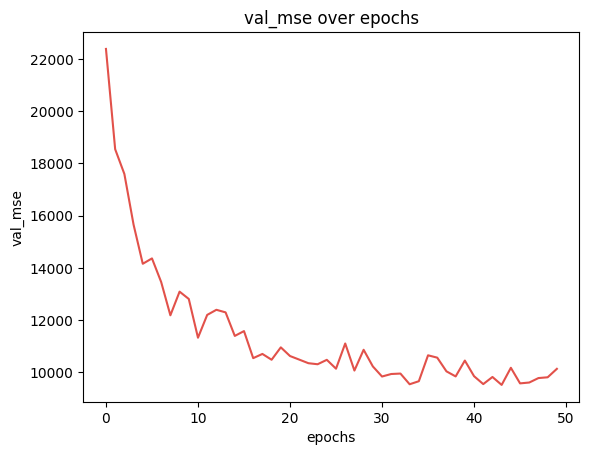

In [49]:
fit = history.history
for i in fit:
    plt.plot(fit[i])
    plt.title(i + ' over epochs')
    plt.ylabel(i)
    plt.xlabel('epochs')
    plt.show()

In [50]:
scores = model.evaluate(xtest, ytest)
mae = scores[0]
mse = scores[1]
print('Mean absolute error: ', mae)

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 45.0875 - mse: 10099.8076
Mean absolute error:  43.55474853515625


In [53]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(ytest, model.predict(xtest))

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


43.55474830922821

# Saving the model (for reference)

In [56]:
model.save('keras-model.keras')